In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dt = 0.001                       # timestep
n = 10000                        # nr of timesteps
x = np.zeros(n)                 # variables
y = np.zeros(n)
z = np.zeros(n)
dxdt = np.zeros(n)              # first derivative
xdt = np.zeros(n)
ydt = np.zeros(n)
zdt = np.zeros(n)
dydt = np.zeros(n)
dzdt = np.zeros(n)
sigma = 10                      # constants
beta = 2.7
rho = 28
b=0.01

In [4]:
x[0] =-8         # initial positions
y[0] = 7
z[0] = 27


In [5]:
"""generates the chaotic lorenz system at the given initial positions using fourth order runge kutta scheme"""


def generate(x,y,z,dt):
    
    for i in range(n-1):
        
        k1 = dt* sigma*(y[i]-x[i])
        k2 = dt* sigma*(y[i]-(x[i]+0.5*k1))
        k3 = dt*sigma*(y[i]- (x[i]+0.5*k2))
        k4 = dt*sigma*(y[i]-(x[i]+k3))
        
        x[i+1] = x[i] + (k1+2*k2+2*k3+k4)/6 + b*np.sqrt(dt)*np.random.normal()
        
        k1 = dt*(x[i]*(rho-z[i])-y[i])
        k2 = dt*(x[i]*(rho-z[i])-(y[i]+0.5*k1))
        k3 = dt*(x[i]*(rho-z[i])-(y[i]+0.5*k2))
        k4 = dt*(x[i]*(rho-z[i])-(y[i]+k3))
        
        y[i+1] = y[i] + (k1+2*k2+2*k3+k4)/6 + b*np.sqrt(dt)*np.random.normal()
        
        k1 = dt*(x[i]*y[i]-(beta*z[i]))
        k2 = dt* (x[i]*y[i]-(beta*(z[i]+k1*0.5)))
        k3 = dt*(x[i]*y[i]-(beta*(z[i]+k2*0.5)))
        k4 = dt*(x[i]*y[i]-(beta*(z[i]+k3)))
        
        z[i+1] = z[i] + (k1+2*k2+2*k3+k4)/6 + b*np.sqrt(dt)*np.random.normal()
        
        '''x[i+1] = x[i] + dt*sigma*(y[i]-x[i]) + b*np.sqrt(dt)*np.random.normal()           # explicit euler step
        y[i+1] = y[i] + dt*((x[i]*(rho-z[i]))-y[i]) + b*np.sqrt(dt)*np.random.normal()
        z[i+1] = z[i] + dt*((x[i]*y[i])-(beta*z[i])) + b*np.sqrt(dt)*np.random.normal()'''
    
    for i in range(n-1):
    
        
        
        dxdt[i]= (x[i+1]-x[i])/dt
        dydt[i] = (y[i+1]-y[i])/dt
        dzdt[i] = (z[i+1]-z[i])/dt
        
  

In [6]:
generate(x,y,z,dt)      # generates the system trajectory

/Applications/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Applications/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


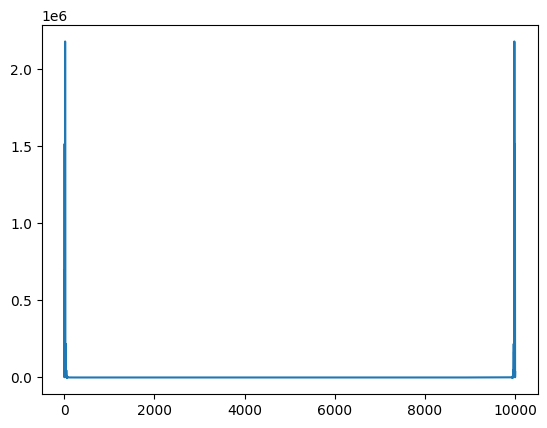

In [7]:
"""the first derivative of the noisy system will significantly amplify the noise and hence the fluctuations from the random force
are smoothed out using a cut off in the fourier space"""

x_hat = np.fft.fft(dxdt)                # tranform into fourier space
power = x_hat*np.conj(x_hat)/(n-1)      # cutoff frequencies at low power
plt.plot(power)


In [8]:
def denoising(x):
    
    x_hat = np.fft.fft(x)                # tranform into fourier space
    power = x_hat*np.conj(x_hat)/(n-1)   # calculate the power spectrum
    ind = power > 3*np.sqrt(dt)*b**2                # threshold the indices with low powerspectrum value
    x_hat = x_hat*ind                    
    return np.real(np.fft.ifft(x_hat))   # tranform to real space

In [9]:
u = denoising(dxdt)
v= denoising(dydt)
w = denoising(dzdt)

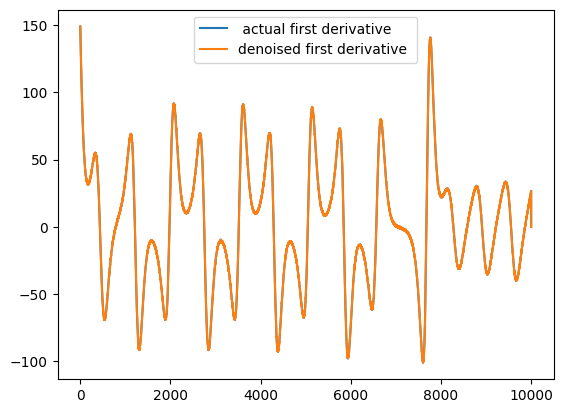

In [11]:
plt.plot(dxdt, label =' actual first derivative')
plt.plot(u , label= 'denoised first derivative ')
plt.legend()

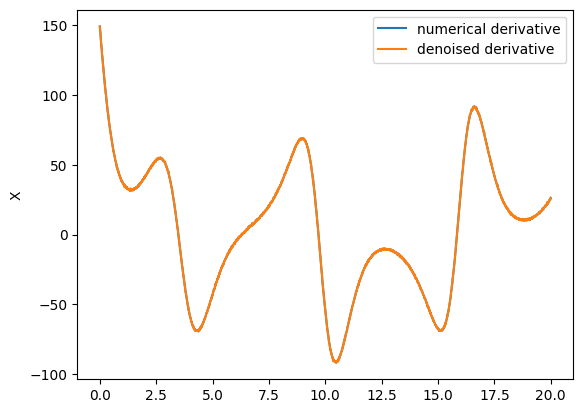

In [12]:

plt.plot(np.linspace(0,20,int(n/4)),dxdt[:int(n/4)],label='numerical derivative')
plt.plot(np.linspace(0,20,int(n/4)),u[:int(n/4)],label='denoised derivative')
plt.ylabel('X')
plt.legend()

Text(0, 0.5, 'Y')

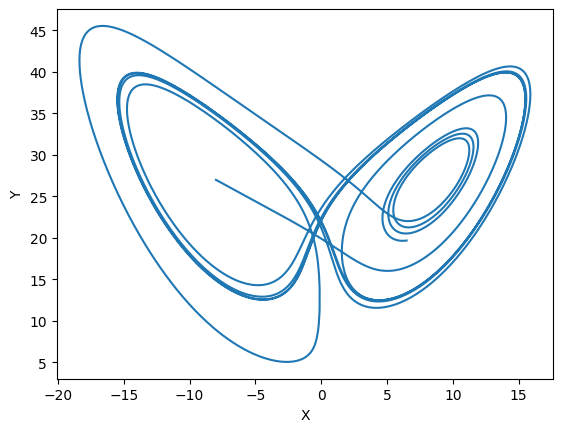

In [13]:
plt.plot(x,z)
plt.xlabel('X')
plt.ylabel('Y')

In [14]:
theta = np.column_stack((np.ones(n),x,y,z,x*x,y*y,z*z,x*y,x*z,y*z,x**3,y**3,z**3,x**2*y,x**2*z,y**2*x,y**2*z,z**2*x,z**2*y,x*y*z,x**4,y**4,z**4,x**3*y,x**3*z,y**3*x,y**3*z,z**3*x,z**3*y,x**2*y**2,z**2*y**2,z**2*x**2,x**5,y**5,z**5,x**4*y,x**4*z,y**4*z,y**4*x,z**4*x,z**4*y,x**3*y**2,x**3*z**2,x**2*y**3,z**2*y**3,z**3*x**2,z**3*y**2,x**3*y*z,y**3*x*z,z**3*y*x))    # dictionary of functions

In [15]:
ddt = np.column_stack((u,v,w))              # first derivative matrix

In [16]:
zeta = np.linalg.lstsq(theta,ddt , rcond=None)[0]    # initial guess

In [17]:
for i in range(100):
    smallinds = np.abs(zeta)<0.1        # thresholding the zeta values
    zeta[smallinds] = 0
    
    for ind in range(3):                  # iterate through state variables
        biginds = ~smallinds[:,ind]       # regress the original problem after thresholding
        zeta[biginds, ind] = np.linalg.lstsq(theta[:, biginds], ddt[:, ind], rcond=None)[0] # new zeta values

In [18]:
zeta

array([[ 0.        ,  0.        ,  0.        ],
       [-9.94949161, 27.98711335,  0.        ],
       [ 9.9491406 , -1.00160692,  0.        ],
       [ 0.        ,  0.        , -2.69643834],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99864829],
       [ 0.        , -0.99949426,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [19]:
X = np.zeros(n)
Y = np.zeros(n)
Z = np.zeros(n)
X[0] = x[0]         # initial positions
Y[0] = y[0]
Z[0] = z[0]
print(x[0],y[0],z[0])

-8.0 7.0 27.0


In [20]:
def regenerate(n,dt):
    for i in range(n-1):
        X[i+1] = X[i] + np.array([1,X[i],Y[i],Z[i],X[i]*X[i],Y[i]*Y[i],Z[i]*Z[i],X[i]*Y[i],X[i]*Z[i],Y[i]*Z[i],X[i]**3,Y[i]**3,Z[i]**3,X[i]**2*Y[i],X[i]**2*Z[i],Y[i]**2*X[i],Y[i]**2*Z[i],Z[i]**2*X[i],Z[i]**2*Y[i],X[i]*Y[i]*Z[i],X[i]**4,Y[i]**4,Z[i]**4,X[i]**3*Y[i],X[i]**3*Z[i],Y[i]**3*X[i],Y[i]**3*Z[i],Z[i]**3*X[i],Z[i]**3*Y[i],X[i]**2*Y[i]**2,Z[i]**2*Y[i]**2,Z[i]**2*X[i]**2,X[i]**5,Y[i]**5,Z[i]**5,X[i]**4*Y[i],X[i]**4*Z[i],Y[i]**4*Z[i],Y[i]**4*X[i],Z[i]**4*X[i],Z[i]**4*Y[i],X[i]**3*Y[i]**2,X[i]**3*Z[i]**2,X[i]**2*Y[i]**3,Z[i]**2*Y[i]**3,Z[i]**3*X[i]**2,Z[i]**3*Y[i]**2,X[i]**3*Y[i]*Z[i],Y[i]**3*X[i]*Z[i],Z[i]**3*Y[i]*X[i]]@zeta[:,0])*dt
        Y[i+1] = Y[i] + np.array([1,X[i],Y[i],Z[i],X[i]*X[i],Y[i]*Y[i],Z[i]*Z[i],X[i]*Y[i],X[i]*Z[i],Y[i]*Z[i],X[i]**3,Y[i]**3,Z[i]**3,X[i]**2*Y[i],X[i]**2*Z[i],Y[i]**2*X[i],Y[i]**2*Z[i],Z[i]**2*X[i],Z[i]**2*Y[i],X[i]*Y[i]*Z[i],X[i]**4,Y[i]**4,Z[i]**4,X[i]**3*Y[i],X[i]**3*Z[i],Y[i]**3*X[i],Y[i]**3*Z[i],Z[i]**3*X[i],Z[i]**3*Y[i],X[i]**2*Y[i]**2,Z[i]**2*Y[i]**2,Z[i]**2*X[i]**2,X[i]**5,Y[i]**5,Z[i]**5,X[i]**4*Y[i],X[i]**4*Z[i],Y[i]**4*Z[i],Y[i]**4*X[i],Z[i]**4*X[i],Z[i]**4*Y[i],X[i]**3*Y[i]**2,X[i]**3*Z[i]**2,X[i]**2*Y[i]**3,Z[i]**2*Y[i]**3,Z[i]**3*X[i]**2,Z[i]**3*Y[i]**2,X[i]**3*Y[i]*Z[i],Y[i]**3*X[i]*Z[i],Z[i]**3*Y[i]*X[i]]@zeta[:,1])*dt
        Z[i+1] = Z[i] + np.array([1,X[i],Y[i],Z[i],X[i]*X[i],Y[i]*Y[i],Z[i]*Z[i],X[i]*Y[i],X[i]*Z[i],Y[i]*Z[i],X[i]**3,Y[i]**3,Z[i]**3,X[i]**2*Y[i],X[i]**2*Z[i],Y[i]**2*X[i],Y[i]**2*Z[i],Z[i]**2*X[i],Z[i]**2*Y[i],X[i]*Y[i]*Z[i],X[i]**4,Y[i]**4,Z[i]**4,X[i]**3*Y[i],X[i]**3*Z[i],Y[i]**3*X[i],Y[i]**3*Z[i],Z[i]**3*X[i],Z[i]**3*Y[i],X[i]**2*Y[i]**2,Z[i]**2*Y[i]**2,Z[i]**2*X[i]**2,X[i]**5,Y[i]**5,Z[i]**5,X[i]**4*Y[i],X[i]**4*Z[i],Y[i]**4*Z[i],Y[i]**4*X[i],Z[i]**4*X[i],Z[i]**4*Y[i],X[i]**3*Y[i]**2,X[i]**3*Z[i]**2,X[i]**2*Y[i]**3,Z[i]**2*Y[i]**3,Z[i]**3*X[i]**2,Z[i]**3*Y[i]**2,X[i]**3*Y[i]*Z[i],Y[i]**3*X[i]*Z[i],Z[i]**3*Y[i]*X[i]]@zeta[:,2])*dt

In [21]:
regenerate(n,dt)

In [22]:
def generate1(x,y,z,dt):
    
    for i in range(n-1):
        
        k1 = dt* sigma*(y[i]-x[i])
        k2 = dt* sigma*(y[i]-(x[i]+0.5*k1))
        k3 = dt*sigma*(y[i]- (x[i]+0.5*k2))
        k4 = dt*sigma*(y[i]-(x[i]+k3))
        
        x[i+1] = x[i] + (k1+2*k2+2*k3+k4)/6 
        
        k1 = dt*(x[i]*(rho-z[i])-y[i])
        k2 = dt*(x[i]*(rho-z[i])-(y[i]+0.5*k1))
        k3 = dt*(x[i]*(rho-z[i])-(y[i]+0.5*k2))
        k4 = dt*(x[i]*(rho-z[i])-(y[i]+k3))
        
        y[i+1] = y[i] + (k1+2*k2+2*k3+k4)/6 
        
        k1 = dt*(x[i]*y[i]-(beta*z[i]))
        k2 = dt* (x[i]*y[i]-(beta*(z[i]+k1*0.5)))
        k3 = dt*(x[i]*y[i]-(beta*(z[i]+k2*0.5)))
        k4 = dt*(x[i]*y[i]-(beta*(z[i]+k3)))
        
        z[i+1] = z[i] + (k1+2*k2+2*k3+k4)/6 

In [23]:
generate1(x,y,z,dt)

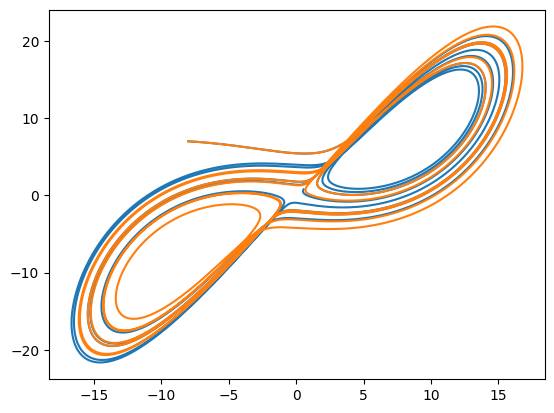

In [24]:
plt.plot(X,Y)
plt.plot(x,y)

In [25]:
np.array([1,X[i],Y[i],Z[i],X[i]*X[i],Y[i]*Y[i],Z[i]*Z[i],X[i]*Y[i],X[i]*Z[i],Y[i]*Z[i],X[i]**3,Y[i]**3,Z[i]**3,X[i]**2*Y[i],X[i]**2*Z[i],Y[i]**2*X[i],Y[i]**2*Z[i],Z[i]**2*X[i],Z[i]**2*Y[i],X[i]*Y[i]*Z[i],X[i]**4,Y[i]**4,Z[i]**4,X[i]**3*Y[i],X[i]**3*Z[i],Y[i]**3*X[i],Y[i]**3*Z[i],Z[i]**3*X[i],Z[i]**3*Y[i],X[i]**2*Y[i]**2,Z[i]**2*Y[i]**2,Z[i]**2*X[i]**2,X[i]**5,Y[i]**5,Z[i]**5,X[i]**4*Y[i],X[i]**4*Z[i],Y[i]**4*Z[i],Y[i]**4*X[i],Z[i]**4*X[i],Z[i]**4*Y[i],X[i]**3*Y[i]**2,X[i]**3*Z[i]**2,X[i]**2*Y[i]**3,Z[i]**2*Y[i]**3,Z[i]**3*X[i]**2,Z[i]**3*Y[i]**2,X[i]**3*Y[i]*Z[i],Y[i]**3*X[i]*Z[i],Z[i]**3*Y[i]*X[i]]*zeta[:,0]).shape

(50,)

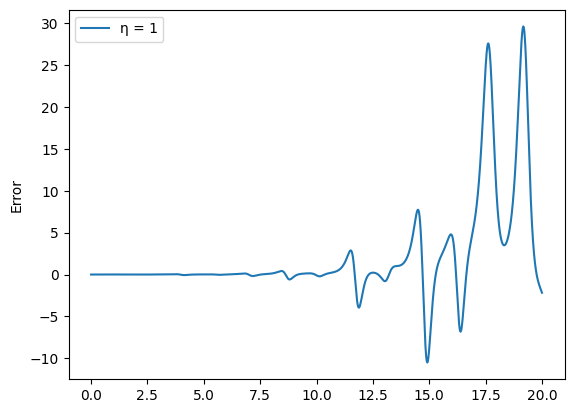

In [26]:
plt.plot(np.linspace(0,20,n),(X-x),label='η = 1')

#plt.plot(np.linspace(0,20,n),(X2-x2),label='η = 0.1')
#plt.plot(np.linspace(0,20,n),(X1-x1),label='η = 0.01')
plt.ylabel('Error')
plt.legend()
plt.show()

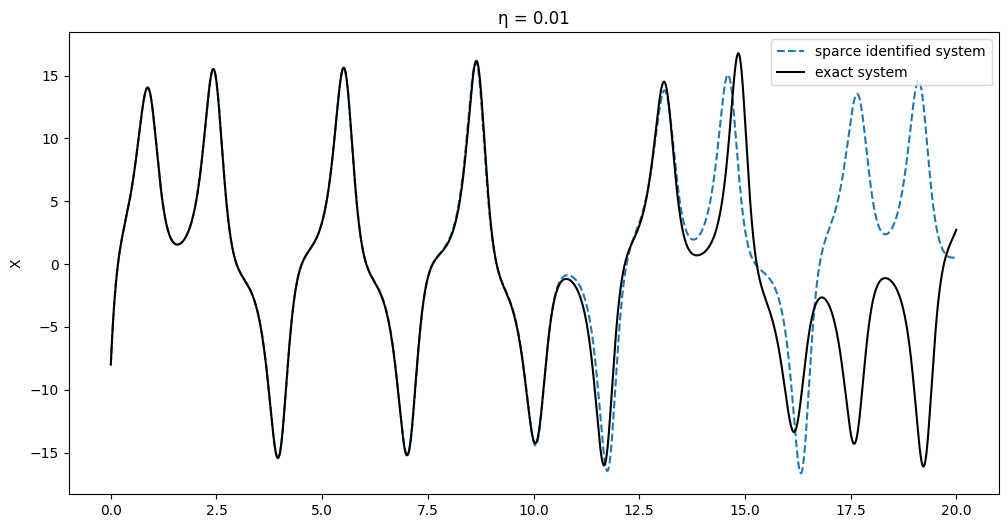

In [27]:
figure = plt.figure(figsize=(12,6))
plt.plot(np.linspace(0,20,10000),X[:10000],'--',label='sparce identified system')
plt.plot(np.linspace(0,20,10000),x[:10000],'k',label='exact system')
plt.legend()
plt.title('η = '+ str(b))
plt.ylabel('X')
plt.show()


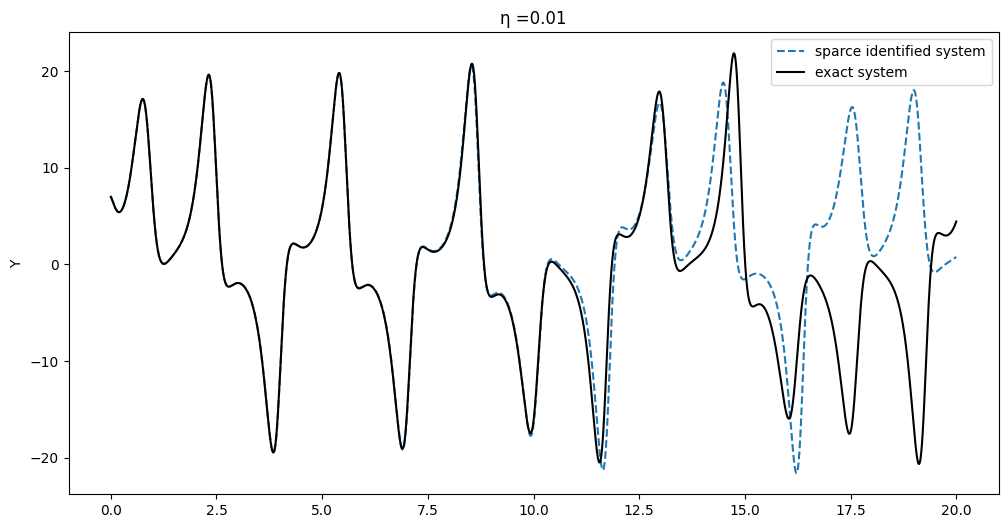

In [28]:

figure = plt.figure(figsize=(12,6))
plt.plot(np.linspace(0,20,10000),Y[:10000],'--',label='sparce identified system')
plt.plot(np.linspace(0,20,10000),y[:10000],'k',label='exact system')
plt.legend()
plt.title('η ='+str(b))
plt.ylabel('Y')
plt.show()